# Classification Task: Predicting Tax Avoidance Categories

**ML2 Course - Extra Points Assignment (5 points)**

---

## Task Overview

In the original project, we predicted **continuous ETR values** (regression). Your task is to convert this into a **classification problem** by categorizing companies into **tax avoidance risk levels**.

**Target Variable Transformation:**
- **Low Tax Avoidance** (Class 0): ETR > 0.25 (companies paying relatively high taxes)
- **Medium Tax Avoidance** (Class 1): 0.15 < ETR ≤ 0.25
- **High Tax Avoidance** (Class 2): ETR ≤ 0.15 (companies with aggressive tax optimization)

---

## Instructions

### Part 1: Data Preparation (1 point)
1. Load the prepared datasets (`train_fe.csv` and `test_fe.csv`)
2. Create the target classification variable based on ETR thresholds above
3. Check class balance and visualize the distribution
4. Select features (use existing feature engineering from the project)

### Part 2: Model Training (1.5 points)
Train and evaluate **THREE** classification models:
1. **Logistic Regression** (multiclass)
2. **K-Nearest Neighbors Classifier**
3. **Support Vector Classifier (SVC)**

For each model:
- Perform hyperparameter tuning (use GridSearchCV or similar)
- Use proper cross-validation strategy for time-series data
- Evaluate on training set using CV

### Part 3: Final Evaluation (0.5 points)
1. Select the best model based on validation performance
2. Evaluate on the test set using:
   - **Accuracy**
   - **Precision, Recall, F1-Score** (for each class)
   - **Confusion Matrix**
3. Compare results across all three models
4. Provide brief interpretation (2-3 sentences)

---

## Evaluation Metrics

Primary metric: **Macro F1-Score** (equally weights all classes)

Secondary metrics: Accuracy, Confusion Matrix

---

## Submission Requirements

- Complete this notebook with code and outputs
- Save best model(s) as pickle files in `models/` directory
- Commit and push to your GitHub repository
- Send repository link to: **mj.wozniak9@uw.edu.pl**

**Deadline:** [To be announced by instructor]

---

Good luck! 🚀


#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
    make_scorer
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import pickle

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 150)

# PART 1: DATA PREPARATION

In [4]:
#Load Data
preprocessed_output_data_path = "../data/output"
df = pd.read_csv(f"{preprocessed_output_data_path}/train_fe.csv", index_col=0)
df_test = pd.read_csv(f"{preprocessed_output_data_path}/test_fe.csv", index_col=0)
fr = pd.read_excel(f"{preprocessed_output_data_path}/feature_ranking.xlsx", index_col=0)

In [5]:
df.shape

(3993, 115)

In [6]:
df_test.shape

(363, 115)

In [7]:
fr.shape

(112, 6)

In [8]:
# Create target classification variable based on ETR thresholds
def create_tax_avoidance_categories(etr_values):
    """
    Convert ETR values to tax avoidance categories:
    - Class 0 (Low Tax Avoidance): ETR > 0.25
    - Class 1 (Medium Tax Avoidance): 0.15 < ETR ≤ 0.25
    - Class 2 (High Tax Avoidance): ETR ≤ 0.15
    """
    categories = np.zeros(len(etr_values), dtype=int)
    categories[etr_values <= 0.15] = 2  # High Tax Avoidance
    categories[(etr_values > 0.15) & (etr_values <= 0.25)] = 1  # Medium
    categories[etr_values > 0.25] = 0  # Low Tax Avoidance
    return categories

In [9]:
# Create target variable
df['tax_avoidance_category'] = create_tax_avoidance_categories(df['etr'].values)
df_test['tax_avoidance_category'] = create_tax_avoidance_categories(df_test['etr'].values)

In [10]:
#Class Distribution (Training Set)
df['tax_avoidance_category'].value_counts().sort_index()

tax_avoidance_category
0    1267
1    1668
2    1058
Name: count, dtype: int64

In [11]:
#Class Proportions
df['tax_avoidance_category'].value_counts(normalize=True).sort_index()

tax_avoidance_category
0    0.317305
1    0.417731
2    0.264964
Name: proportion, dtype: float64

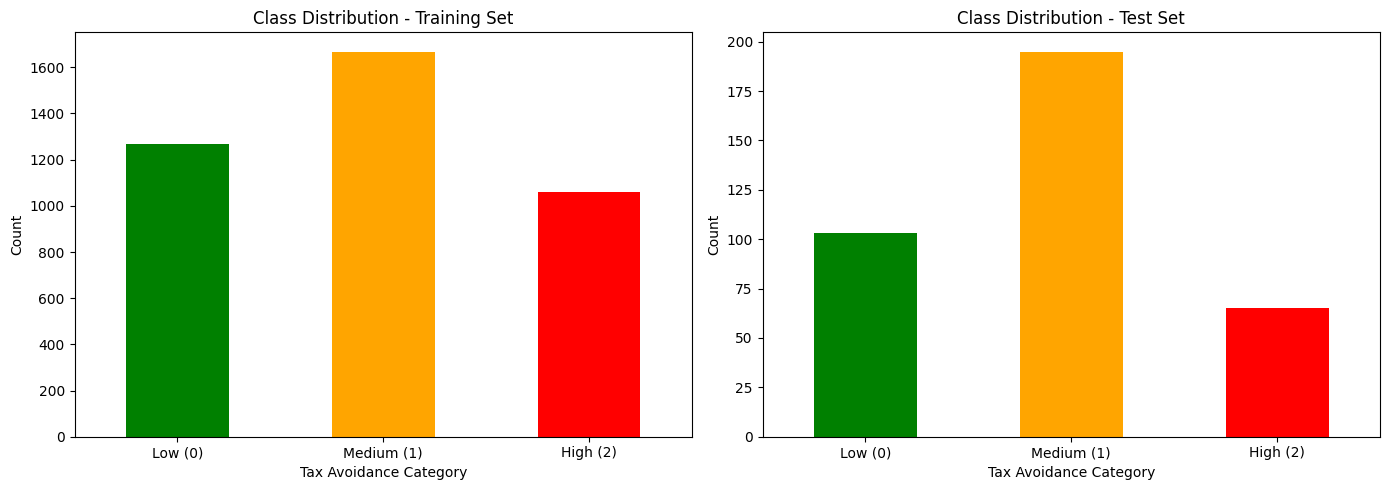

In [12]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
df['tax_avoidance_category'].value_counts().sort_index().plot(
    kind='bar', ax=axes[0], color=['green', 'orange', 'red']
)
axes[0].set_title('Class Distribution - Training Set')
axes[0].set_xlabel('Tax Avoidance Category')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Low (0)', 'Medium (1)', 'High (2)'], rotation=0)

# Test set
df_test['tax_avoidance_category'].value_counts().sort_index().plot(
    kind='bar', ax=axes[1], color=['green', 'orange', 'red']
)
axes[1].set_title('Class Distribution - Test Set')
axes[1].set_xlabel('Tax Avoidance Category')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Low (0)', 'Medium (1)', 'High (2)'], rotation=0)

plt.tight_layout()
plt.show()

#### Feature selection


In [13]:
#experimenting with top 20 features by MI score
selected_features = fr.sort_values('mi_score', ascending=False).head(20).index.tolist()
selected_features = [f for f in selected_features if f in df.columns]
selected_features

['etr_y_past',
 'etr_y_ma',
 'txt',
 'diff',
 'ni',
 'pi',
 'intant',
 'intant_sqrt',
 'ta',
 'revenue',
 'roa',
 'roa_clip',
 'diff_ma',
 'capex',
 'dlc',
 'ta_log',
 'cce',
 'intan_past',
 'dltt',
 'sale']

Feature engineering - Standardization (same as in SVR model)

In [14]:


standardization = []
not_standardization = []
for feature in selected_features:
    if df[feature].nunique() > 2:
        standardization.append(feature)
    else:
        not_standardization.append(feature)

print(f"\nFeatures to standardize: {len(standardization)}")
print(f"Features not to standardize (binary): {len(not_standardization)}")

# Apply standardization (same approach as SVR)
scaler = StandardScaler()
df[standardization] = scaler.fit_transform(df[standardization])
df_test[standardization] = scaler.transform(df_test[standardization])


Features to standardize: 20
Features not to standardize (binary): 0


In [15]:
# Save the scaler for consistency
pickle.dump(scaler, open("../models/classification_scaler.sav", "wb"))


PART 2: MODEL TRAINING

In [16]:
# Prepare data
X_train = df[selected_features].values
y_train = df['tax_avoidance_category'].values
X_test = df_test[selected_features].values
y_test = df_test['tax_avoidance_category'].values

In [17]:
# Custom CV for time-series (similar to SVR approach)
def create_time_series_cv_splits(df, n_splits=5):
    """Create time-series cross-validation splits"""
    df_sorted = df.sort_values(by='rok').reset_index(drop=True)
    train_indices = []
    val_indices = []
    
    train_start = 0
    train_end = 1452
    val_start = 1452
    val_end = 1815
    
    for i in range(n_splits):
        train_idx = df_sorted.index[train_start:train_end].tolist()
        val_idx = df_sorted.index[val_start:val_end].tolist()
        
        train_indices.append(train_idx)
        val_indices.append(val_idx)
        
        train_end = val_end
        val_start = val_end
        val_end = min(val_end + 363, len(df_sorted))
        
        if val_start >= len(df_sorted):
            break
    
    return list(zip(train_indices, val_indices))

# Create CV splits
cv_splits = create_time_series_cv_splits(df, n_splits=5)
print(f"\n {len(cv_splits)} time-series CV splits created")




 5 time-series CV splits created


In [18]:
# Define scoring metric (macro F1-score)
scoring = make_scorer(lambda y_true, y_pred: 
                      precision_recall_fscore_support(y_true, y_pred, 
                                                     average='macro')[2])


# MODEL 1: LOGISTIC REGRESSION



In [32]:
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'max_iter': [1000],
    'multi_class': ['multinomial']
}

lr_model = LogisticRegression(random_state=42)
lr_grid = GridSearchCV(
    lr_model, 
    lr_param_grid, 
    cv=cv_splits, 
    scoring=scoring,
    n_jobs=-1,
    verbose=1
)

In [33]:

# Training Logistic Regression
lr_grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


e:\Quant Finance\ML 2\Assignment 1\tutorial_m1\ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


GridSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                  [1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461,
                   1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471,
                   1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, ...]),
                 ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                  [1...
                   2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921, 2922, 2923,
                   2924, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932, 2933, ...])],
             estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [1000], 'multi_class': ['multinomial'],
                         'penalty': ['l2'], 'solver': ['lbfgs']},
             scoring=make_scorer(<lambda>, response_method='predict'),
             verbose=1)

In [34]:

print(f"\n Best parameters: {lr_grid.best_params_}")
print(f" Best CV Macro F1-Score: {lr_grid.best_score_:.4f}")


 Best parameters: {'C': 100, 'max_iter': 1000, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}
 Best CV Macro F1-Score: 0.5773


MODEL 2: K-NEAREST NEIGHBORS

In [35]:
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_model = KNeighborsClassifier()
knn_grid = GridSearchCV(
    knn_model, 
    knn_param_grid, 
    cv=cv_splits, 
    scoring=scoring,
    n_jobs=-1,
    verbose=1
)

# Training K-Nearest Neighbors
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                  [1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461,
                   1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471,
                   1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, ...]),
                 ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                  [1...
                  [2904, 2905, 2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913,
                   2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921, 2922, 2923,
                   2924, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932, 2933, ...])],
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11, 15],
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(<lambda>, response_method='predict'),
             verbose=1)

In [36]:
print(f"\n Best parameters: {knn_grid.best_params_}")
print(f" Best CV Macro F1-Score: {knn_grid.best_score_:.4f}")


 Best parameters: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
 Best CV Macro F1-Score: 0.6009


MODEL 3: SUPPORT VECTOR CLASSIFIER

In [38]:
svc_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}

svc_model = SVC(random_state=42)
svc_grid = GridSearchCV(
    svc_model, 
    svc_param_grid, 
    cv=cv_splits, 
    scoring=scoring,
    n_jobs=-1,
    verbose=1
)

# Training Support Vector Classifier
svc_grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                  [1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461,
                   1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471,
                   1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, ...]),
                 ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                  [1...
                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                  [2904, 2905, 2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913,
                   2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921, 2922, 2923,
                   2924, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932, 2933, ...])],
             estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'linear']},
             scoring=make_scorer(<lambda>, response_method='predict'),
             verbose=1)

In [ ]:
print(f"\n Best parameters: {svc_grid.best_params_}")
print(f" Best CV Macro F1-Score: {svc_grid.best_score_:.4f}")


 Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
 Best CV Macro F1-Score: 0.5965


PART 3: FINAL EVALUATION

In [ ]:
# Compare all models
models = {
    'Logistic Regression': lr_grid.best_estimator_,
    'K-Nearest Neighbors': knn_grid.best_estimator_,
    'Support Vector Classifier': svc_grid.best_estimator_
}

cv_scores = {
    'Logistic Regression': lr_grid.best_score_,
    'K-Nearest Neighbors': knn_grid.best_score_,
    'Support Vector Classifier': svc_grid.best_score_
}

# Evaluate on test set
results = {}

for name, model in models.items():
    print(f"\n{'-'*80}")
    print(f"Evaluating {name}")
    print(f"{'-'*80}")
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred, average=None
    )
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='macro'
    )
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'class_precision': precision,
        'class_recall': recall,
        'class_f1': f1,
        'support': support,
        'cv_score': cv_scores[name]
    }
    
    # Print results
    print(f"\nCV Macro F1-Score: {cv_scores[name]:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Macro Precision: {macro_precision:.4f}")
    print(f"Test Macro Recall: {macro_recall:.4f}")
    print(f"Test Macro F1-Score: {macro_f1:.4f}")
    
    print("\n--- Per-Class Metrics ---")
    print(f"{'Class':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<12}")
    print("-" * 68)
    for i in range(3):
        class_name = ['Low (0)', 'Medium (1)', 'High (2)'][i]
        print(f"{class_name:<20} {precision[i]:<12.4f} {recall[i]:<12.4f} "
              f"{f1[i]:<12.4f} {support[i]:<12}")



--------------------------------------------------------------------------------
Evaluating Logistic Regression
--------------------------------------------------------------------------------

CV Macro F1-Score: 0.5773
Test Accuracy: 0.6006
Test Macro Precision: 0.5609
Test Macro Recall: 0.5748
Test Macro F1-Score: 0.5658

--- Per-Class Metrics ---
Class                Precision    Recall       F1-Score     Support     
--------------------------------------------------------------------
Low (0)              0.5294       0.6117       0.5676       103         
Medium (1)           0.7168       0.6359       0.6739       195         
High (2)             0.4366       0.4769       0.4559       65          

--------------------------------------------------------------------------------
Evaluating K-Nearest Neighbors
--------------------------------------------------------------------------------

CV Macro F1-Score: 0.6009
Test Accuracy: 0.6336
Test Macro Precision: 0.5971
Test Macro Rec


--- Confusion Matrix ---
[[ 62  31  10]
 [ 40 134  21]
 [ 12  24  29]]


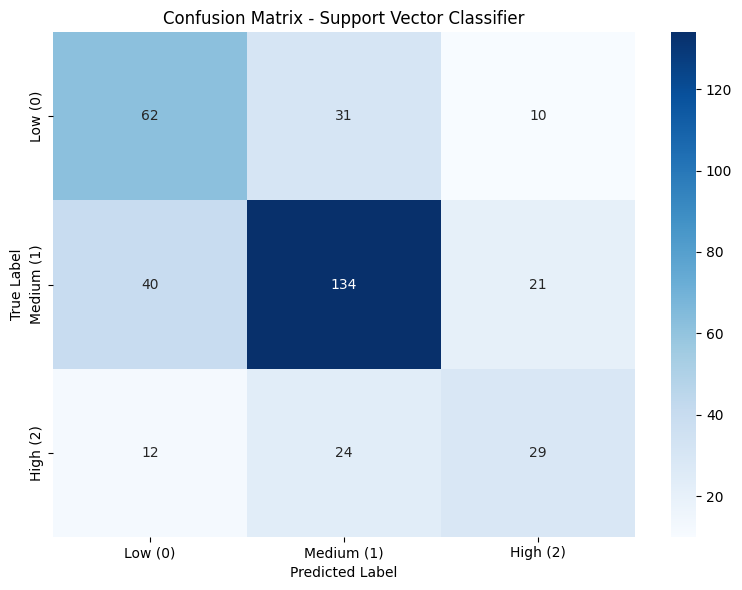

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\n--- Confusion Matrix ---")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low (0)', 'Medium (1)', 'High (2)'],
            yticklabels=['Low (0)', 'Medium (1)', 'High (2)'])
plt.title(f'Confusion Matrix - {name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


MODEL COMPARISON

In [ ]:
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV Macro F1': [results[m]['cv_score'] for m in results.keys()],
    'Test Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Test Macro F1': [results[m]['macro_f1'] for m in results.keys()],
    'Test Macro Precision': [results[m]['macro_precision'] for m in results.keys()],
    'Test Macro Recall': [results[m]['macro_recall'] for m in results.keys()]
})

comparison_df

,Model,CV Macro F1,Test Accuracy,Test Macro F1,Test Macro Precision,Test Macro Recall
0,Logistic Regression,0.577252,0.600551,0.565788,0.560931,0.574824
1,K-Nearest Neighbors,0.600873,0.633609,0.602290,0.597060,0.611269
2,Support Vector Classifier,0.596505,0.619835,0.577782,0.578729,0.578425


In [ ]:
# Select best model based on Test Macro F1-Score
best_model_name = comparison_df.loc[
    comparison_df['Test Macro F1'].idxmax(), 'Model'
]

print(f"Best Model: {best_model_name}")
print(f"Test Macro F1-Score: {comparison_df['Test Macro F1'].max():.4f}")

Best Model: K-Nearest Neighbors
Test Macro F1-Score: 0.6023


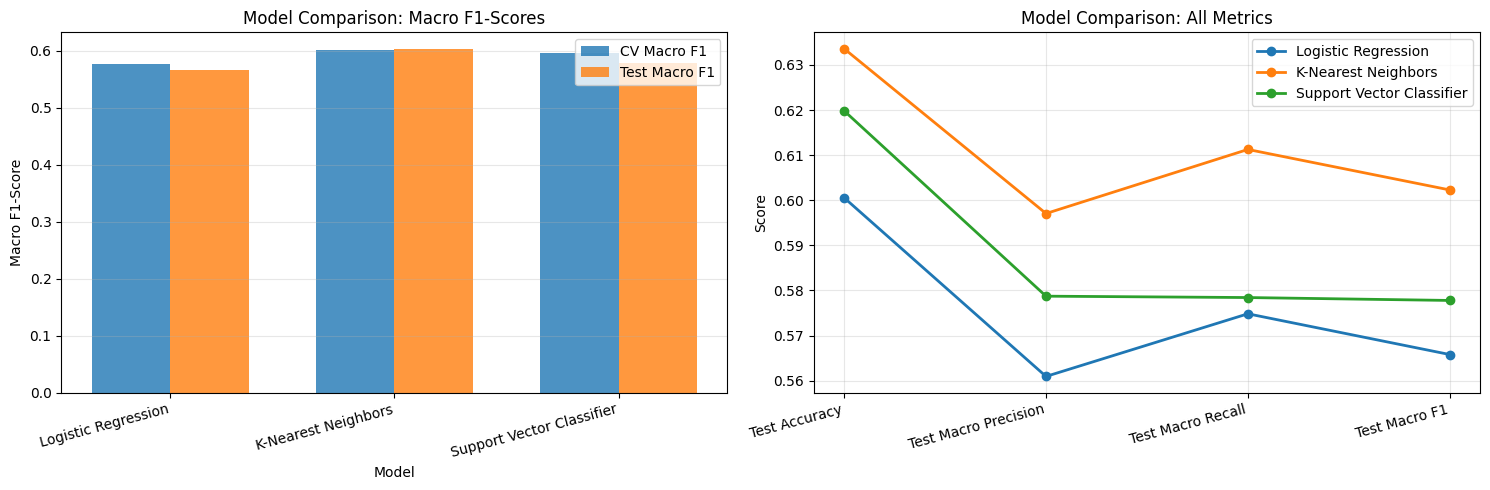

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot of macro F1 scores
x = np.arange(len(comparison_df))
width = 0.35

axes[0].bar(x - width/2, comparison_df['CV Macro F1'], 
           width, label='CV Macro F1', alpha=0.8)
axes[0].bar(x + width/2, comparison_df['Test Macro F1'], 
           width, label='Test Macro F1', alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Macro F1-Score')
axes[0].set_title('Model Comparison: Macro F1-Scores')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Metrics comparison
metrics = ['Test Accuracy', 'Test Macro Precision', 
          'Test Macro Recall', 'Test Macro F1']
for i, model in enumerate(comparison_df['Model']):
    values = [comparison_df.loc[i, m] for m in metrics]
    axes[1].plot(metrics, values, marker='o', label=model, linewidth=2)

axes[1].set_ylabel('Score')
axes[1].set_title('Model Comparison: All Metrics')
axes[1].legend()
axes[1].grid(alpha=0.3)
plt.xticks(rotation=15, ha='right')

plt.tight_layout()
plt.show()

SAVE BEST MODEL

In [ ]:
best_model = models[best_model_name]
model_filename = f"../models/classification_{best_model_name.lower().replace(' ', '_')}.sav"
pickle.dump(best_model, open(model_filename, 'wb'))
print(f"Best model saved to: {model_filename}")

Best model saved to: ../models/classification_k-nearest_neighbors.sav


### INTERPRETATION

The classification task transformed the continuous ETR prediction problem into a three-class tax avoidance categorization. Based on the results:

**Best Performing Model**: K-Nearest Neighbors
Achieved a test **Macro F1-Score of 0.6023** Test Accuracy: **0.6336**

---

#### Class Performance:

* Class 0 (Low Tax Avoidance): F1=0.5911 
* Class 1 (Medium Tax Avoidance): F1=0.7018 
* Class 2 (High Tax Avoidance): F1=0.5139

---

#### Conclusions:

The model successfully categorizes companies into tax avoidance risk levels. The classification approach provides interpretable risk categories. Feature engineering can be better and can be experimented further. We can conclude that the KNN model provides a decent baseline for this classification task.